In [1]:
import pandas as pd
import geopandas as gpd
import maup
import time
from maup import smart_repair
from gerrychain import Graph

maup.progress.enabled = True

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# state = Oklahoma
state_ab = "ok"

## Data
1. Download all the data in directory "ok_data"
2. Extract them all

In [5]:
data_folder = state_ab + "_data/"
population1_data = "./{}{}_pl2020_b/{}_pl2020_p1_b.shp".format(data_folder, state_ab, state_ab)
population2_data = "./{}{}_pl2020_b/{}_pl2020_p2_b.shp".format(data_folder, state_ab, state_ab)
vap_data = "./{}{}_pl2020_b/{}_pl2020_p4_b.shp".format(data_folder, state_ab, state_ab)
vest20_data = "./{}{}_vest_20/{}_vest_20.shp".format(data_folder, state_ab, state_ab)
vest18_data = "./{}{}_vest_18/{}_vest_18.shp".format(data_folder, state_ab, state_ab)
vest16_data = "./{}{}_vest_16/{}_vest_16.shp".format(data_folder, state_ab, state_ab)
cd_data = "./{}{}_cong_2021/{}_cong_2021.shp".format(data_folder, state_ab, state_ab)
send_data = "./{}{}_sldu_2021/{}_sldu_2021.shp".format(data_folder, state_ab, state_ab)
hdist_data = "./{}{}_sldl_2021/{}_sldl_2021.shp".format(data_folder, state_ab, state_ab)
county_data = "./{}{}_pl2020_cnty/{}_pl2020_cnty.shp".format(data_folder, state_ab, state_ab)

In [6]:
def do_smart_repair(df, min_rook_length = None, snap_precision = 10):
    # change it to the UTM it needs for smart_repair
    df = df.to_crs(df.estimate_utm_crs())
    df = smart_repair(df, min_rook_length = min_rook_length, snap_precision = snap_precision)

    if maup.doctor(df) == False:
        raise Exception('maup.doctor failed')
    
    return df

In [7]:
def add_district(dist_df, dist_name, election_df, col_name):
    election_df = election_df.to_crs(election_df.estimate_utm_crs())
    dist_df = dist_df.to_crs(dist_df.estimate_utm_crs())
    # check if it needs to be smart_repair
    if maup.doctor(dist_df) != True:
        dist_df = do_smart_repair(dist_df)

    # assign the pricincts
    precincts_to_district_assignment = maup.assign(election_df.geometry, dist_df.geometry)
    election_df[dist_name] = precincts_to_district_assignment
    for precinct_index in range(len(election_df)):
        election_df.at[precinct_index, dist_name] = dist_df.at[election_df.at[precinct_index, dist_name], col_name]

    return election_df

In [8]:
def rename(original, year):
    party = original[6]
    if party == 'R' or party == 'D':
        return original[3:6] + year + original[6]
    else:
        return original[3:6] + year + 'O'

In [9]:
pop_col = ['TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP']

In [10]:
def check_population(population, df):
    pop_check = pd.DataFrame({
        'pop_col': pop_col,
        'population_df': population[pop_col].sum(), 
        'vest_base': df[pop_col].sum(),
        'equal': [x == y for x, y in zip(population[pop_col].sum(), df[pop_col].sum())]
    })
    if pop_check['equal'].mean() < 1:
        print(pop_check)
        raise Exception("population doesn't agree")

    else:
        print("population agrees")

In [11]:
def add_vest(vest, df, year, population, start_col, snap_precision = 10):
    df = df.to_crs(df.estimate_utm_crs())
    vest = vest.to_crs(vest.estimate_utm_crs())
    population = population.to_crs(population.estimate_utm_crs())
    df_crs = df.crs
    vest_crs = vest.crs
    
     # check if it needs to be smart_repair
    if maup.doctor(vest) != True:
        vest = do_smart_repair(vest, snap_precision = snap_precision)
    
    # rename the columns
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum() # combine all the other party's vote into columns with sufix "O"
    col_name = list(set(new_col))
    col_name.sort()
    
    # make the blocks from precincts by weight
    vest = gpd.GeoDataFrame(vest, crs=vest_crs)
    election_in_block = population[["VAP", 'geometry']] # population_df is in block scale
    blocks_to_precincts_assignment = maup.assign(election_in_block.geometry, vest.geometry)
    weights = election_in_block["VAP"] / blocks_to_precincts_assignment.map(election_in_block["VAP"].groupby(blocks_to_precincts_assignment).sum())
    weights = weights.fillna(0)
    prorated = maup.prorate(blocks_to_precincts_assignment, vest[col_name], weights)
    election_in_block[col_name] = prorated
    
    # assign blocks to precincts
    election_in_block = gpd.GeoDataFrame(election_in_block, crs=vest_crs)
    df = gpd.GeoDataFrame(df, crs=df_crs)
    block_to_pricinct_assginment = maup.assign(election_in_block.geometry, df.geometry)
    df[col_name] = election_in_block[col_name].groupby(block_to_pricinct_assginment).sum()
    df = df.groupby(level=0, axis=1).sum()
    df = gpd.GeoDataFrame(df, crs = df_crs)
    # check if population agrees
    check_population(population, df)
    
    return df

In [12]:
def add_vest_base(vest, start_col, year, county = None, min_rook_length = None, snap_precision = 10):
    vest = vest.to_crs(vest.estimate_utm_crs())
    vest_crs = vest.crs
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum()
    vest = gpd.GeoDataFrame(vest, crs=vest_crs)

    if county is not None:
        county = county.to_crs(county.estimate_utm_crs())
        vest = smart_repair(vest, nest_within_regions = county, min_rook_length = min_rook_length, snap_precision = snap_precision) # nest precincts within counties

    else:
        vest = smart_repair(vest, min_rook_length = min_rook_length, snap_precision = snap_precision) 
    
    return vest

In [13]:
def check_small_boundary_lengths(vest_base):
    import copy
    vest_base = vest_base.to_crs(vest_base.estimate_utm_crs())

    boundaries = copy.deepcopy(vest_base)
    boundaries["geometry"] = boundaries.geometry.boundary  # get boundaries
    neighbors = gpd.sjoin(boundaries, vest_base, predicate="intersects") # find boundaries that intersect
    neighbors = neighbors[neighbors.index != neighbors.index_right] # remove boundaries of a region with itself

    # compute shared border length using intersection
    borders = list(neighbors.apply(
        lambda row: row.geometry.intersection(vest_base.loc[row.index_right, "geometry"]).length, axis=1
    ))

    borders.sort()
    
    return borders

### Read the census data

In [14]:
population1_df = gpd.read_file(population1_data)
population2_df = gpd.read_file(population2_data)
vap_df = gpd.read_file(vap_data)
county_df = gpd.read_file(county_data)

In [15]:
population2_df = population2_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])
vap_df = vap_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])

In [16]:
population_df = pd.merge(population1_df, population2_df, on='GEOID20')
population_df = pd.merge(population_df, vap_df, on='GEOID20')
population_df = population_df.to_crs(population_df.estimate_utm_crs())

In [17]:
maup.doctor(population_df)

100%|███████████████████████████████████| 180154/180154 [01:03<00:00, 2844.82it/s]


True

In [18]:
population_df['H_WHITE'] = population_df.apply(lambda t: t['P0010003'] - t['P0020005'], 1)
population_df['H_BLACK'] = population_df.apply(lambda t: t['P0010004'] - t['P0020006'], 1)
population_df['H_AMIN'] = population_df.apply(lambda t: t['P0010005'] - t['P0020007'], 1)
population_df['H_ASIAN'] = population_df.apply(lambda t: t['P0010006'] - t['P0020008'], 1)
population_df['H_NHPI'] = population_df.apply(lambda t: t['P0010007'] - t['P0020009'], 1)
population_df['H_OTHER'] = population_df.apply(lambda t: t['P0010008'] - t['P0020010'], 1)
population_df['H_2MORE'] = population_df.apply(lambda t: t['P0010009'] - t['P0020011'], 1)

In [19]:
rename_dict = {'P0020001': 'TOTPOP', 'P0020002': 'HISP', 'P0020005': 'NH_WHITE', 'P0020006': 'NH_BLACK', 'P0020007': 'NH_AMIN',
                    'P0020008': 'NH_ASIAN', 'P0020009': 'NH_NHPI', 'P0020010': 'NH_OTHER', 'P0020011': 'NH_2MORE',
                    'P0040001': 'VAP', 'P0040002': 'HVAP', 'P0040005': 'WVAP', 'P0040006': 'BVAP', 'P0040007': 'AMINVAP',
                                        'P0040008': 'ASIANVAP', 'P0040009': 'NHPIVAP', 'P0040010': 'OTHERVAP', 'P0040011': '2MOREVAP'}

In [20]:
population_df.rename(columns=rename_dict, inplace = True)

Make sure that the County shapefile is clean:

In [21]:
maup.doctor(county_df)

100%|████████████████████████████████████████████| 77/77 [00:00<00:00, 379.97it/s]


True

## Read the vest 20 data

Now using it as a "base pricinct"

## Check if vest20 can be used as base

In [22]:
vest20 = gpd.read_file(vest20_data)

In [23]:
vest20.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTY_NAM', 'PCT_CEB', 'GEOID', 'G20PRERTRU',
       'G20PREDBID', 'G20PRELJOR', 'G20PREIWES', 'G20PREISIM', 'G20PREIPIE',
       'G20USSRINH', 'G20USSDBRO', 'G20USSLMUR', 'G20USSIFAR', 'G20USSINES',
       'G20COCRHIE', 'G20COCLHAG', 'geometry'],
      dtype='object')

In [24]:
start_col = 5
vest_base_data = vest20
year = '20'

In [25]:
vest_base = add_vest_base(vest_base_data, start_col, year, county = county_df)

100%|████████████████████████████████████████████| 77/77 [00:00<00:00, 386.32it/s]


Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.


100%|████████████████████████████████████████████| 77/77 [00:00<00:00, 156.46it/s]


Identifying overlaps...


100%|███████████████████████████████████████| 6851/6851 [00:02<00:00, 2339.83it/s]


Resolving overlaps and filling gaps...


Gaps to fill in region 76: 100%|██████████████████| 74/74 [00:00<00:00, 98.35it/s]


In [26]:
borders = check_small_boundary_lengths(vest_base)
print(borders[:1700])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [27]:
vest_base = do_smart_repair(vest_base, min_rook_length = 30.5)

Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|███████████████████████████████████████| 1952/1952 [00:00<00:00, 4141.53it/s]


Resolving overlaps...
Filling gaps...


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]


Converting small rook adjacencies to queen...


100%|███████████████████████████████████████| 1948/1948 [00:01<00:00, 1036.32it/s]


In [28]:
maup.doctor(vest_base)

100%|███████████████████████████████████████| 1948/1948 [00:01<00:00, 1047.53it/s]


True

## If it is true for maup doctor, we will use it as the base vest data.

In [29]:
# vap and population have the same GEOID20
blocks_to_precincts_assignment = maup.assign(population_df.geometry, vest_base.geometry)

100%|████████████████████████████████████████| 1948/1948 [00:07<00:00, 277.62it/s]


In [30]:
vest_base[pop_col] = population_df[pop_col].groupby(blocks_to_precincts_assignment).sum()

In [31]:
election_df = gpd.GeoDataFrame(vest_base)

In [32]:
election_df.columns

Index(['COC20O', 'COC20R', 'COUNTYFP', 'COUNTY_NAM', 'GEOID', 'PCT_CEB',
       'PRE20D', 'PRE20O', 'PRE20R', 'STATEFP', 'USS20D', 'USS20O', 'USS20R',
       'geometry', 'TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN',
       'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'H_WHITE', 'H_BLACK',
       'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP',
       'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP',
       '2MOREVAP'],
      dtype='object')

## Check if population agrees

In [33]:
check_population(population_df, vest_base)

population agrees


## Add more vest data

In [34]:
vest18 = gpd.read_file(vest18_data)

In [35]:
vest18.columns

Index(['COUNTY', 'PRECINCT', 'PCT_CEB', 'G18GOVRSTI', 'G18GOVDEDM',
       'G18GOVLPOW', 'G18LTGRPIN', 'G18LTGDPIT', 'G18LTGIHOL', 'G18ATGRHUN',
       'G18ATGDMYL', 'G18TRERMCD', 'G18TREICOU', 'G18AUDRBYR', 'G18AUDLYEU',
       'G18LABROSB', 'G18LABDDOR', 'G18LABIDIS', 'G18COCRANT', 'G18COCDMCC',
       'G18COCISHO', 'G18INSRMUL', 'G18INSDFOB', 'G18SPIRHOF', 'G18SPIDCOX',
       'G18SPIIHUF', 'geometry'],
      dtype='object')

In [36]:
start_col = 3

In [37]:
election_df = add_vest(vest18, election_df, '18', population_df, start_col)

100%|███████████████████████████████████████| 1951/1951 [00:01<00:00, 1015.90it/s]


There are 91 overlaps.
There are 1085 holes.
There are some invalid geometries.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|███████████████████████████████████████| 3929/3929 [00:00<00:00, 4560.75it/s]


Resolving overlaps...
Assigning order 2 pieces...
Filling gaps...


100%|████████████████████████████████████████| 1948/1948 [00:06<00:00, 281.40it/s]


population agrees


In [38]:
vest16 = gpd.read_file(vest16_data)
vest16.columns

Index(['COUNTY', 'PRECINCT', 'PCT_CEB', 'G16PRERTRU', 'G16PREDCLI',
       'G16PRELJOH', 'G16USSRLAN', 'G16USSDWOR', 'G16USSLMUR', 'G16USSIBRA',
       'G16USSIBEA', 'geometry'],
      dtype='object')

In [39]:
start_col = 3

In [40]:
election_df = add_vest(vest16, election_df, '16', population_df, start_col)

100%|███████████████████████████████████████| 1956/1956 [00:01<00:00, 1057.42it/s]


There are 77 overlaps.
There are 900 holes.
There are some invalid geometries.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|███████████████████████████████████████| 3886/3886 [00:00<00:00, 4477.09it/s]


Resolving overlaps...
Assigning order 2 pieces...
Filling gaps...


100%|████████████████████████████████████████| 1948/1948 [00:07<00:00, 277.94it/s]


population agrees


In [41]:
maup.doctor(election_df)

100%|███████████████████████████████████████| 1948/1948 [00:01<00:00, 1029.51it/s]


True

##  Add the district data

In [42]:
cd = gpd.read_file(cd_data)
cd = cd.to_crs(cd.estimate_utm_crs())
send = gpd.read_file(send_data)
send = send.to_crs(send.estimate_utm_crs())
hdist = gpd.read_file(hdist_data)
hdist = hdist.to_crs(hdist.estimate_utm_crs())

In [43]:
cd.head()

,ID,AREA,DISTRICT,MEMBERS,LOCKED,NAME,POPULATION,NH_WHT,AP_BLK,AP_IND,...,F_18_AP_OT,F_H18_POP,DISTRICT_N,IDEAL_VALU,ALTERNATE1,POLSBY_PO1,PERIMETER,REOCK,DISTRICT_L,geometry
0,1,1103.29736,1,1.0,None,None,791871,453790,91759,116914,...,0.096458,0.114364,1,791871.0,1.747803,0.327352,205.799220,0.441113,1|0%,"POLYGON ((816202.505 3984725.649, 816189.737 3..."
1,2,22414.75580,2,1.0,None,None,791871,478909,38478,231916,...,0.035639,0.043381,2,791871.0,1.924938,0.269877,1021.618270,0.440439,2|0%,"POLYGON ((811881.294 3995970.634, 811877.469 3..."
2,3,32900.69920,3,1.0,None,None,791871,476024,54778,94321,...,0.132794,0.169740,3,791871.0,2.063943,0.234749,1327.104660,0.271145,3|0%,"POLYGON ((480968.830 3799683.878, 480906.451 3..."
3,4,9891.65234,4,1.0,None,None,791870,506779,83688,105607,...,0.064828,0.083481,4,791871.0,1.994284,0.251435,703.115089,0.456904,4|-0%,"POLYGON ((480968.830 3799683.878, 480973.430 3..."
4,5,3584.01245,5,1.0,None,None,791870,491686,113995,85073,...,0.067048,0.081718,5,791871.0,1.708146,0.342728,362.505625,0.499027,5|-0%,"POLYGON ((667716.715 3979112.164, 667787.241 3..."


In [44]:
election_df = add_district(cd, "CD", election_df, "DISTRICT")

100%|███████████████████████████████████████████████| 5/5 [00:00<00:00, 12.71it/s]


In [45]:
send.head()

,ID,AREA,DISTRICT,MEMBERS,LOCKED,NAME,POPULATION,WHITE,BLACK,AMINDIAN,...,DEVIATION,F_DEVIATIO,F_WHITE,F_BLACK,F_AMINDIAN,F_HISPANIC,F_AP_BLK,F_18_HISPA,DISTRICT_L,geometry
0,4,13625.35050,27,1.0,None,None,80552,58226,1673,2189,...,-1935.0,-0.023458,0.722837,0.020769,0.027175,0.231925,0.029012,0.000019,27|-2.35%,"POLYGON ((409700.240 3971237.658, 409703.907 3..."
1,5,5809.40576,38,1.0,None,None,81575,60304,4313,2771,...,-912.0,-0.011056,0.739246,0.052872,0.033969,0.170175,0.070451,0.000013,38|-1.11%,"POLYGON ((480968.830 3799683.878, 480906.451 3..."
2,6,4388.56640,5,1.0,None,None,81765,53059,3431,12164,...,-722.0,-0.008753,0.648921,0.041962,0.148768,0.068134,0.059108,-0.000087,5|-0.88%,"POLYGON ((915554.059 3894894.524, 915554.131 3..."
3,10,3380.12451,6,1.0,None,None,83910,55477,2767,13213,...,1423.0,0.017251,0.661149,0.032976,0.157466,0.058646,0.051817,0.000089,6|1.73%,"POLYGON ((855360.755 3761784.445, 855356.870 3..."
4,318,1977.38623,4,1.0,None,None,80677,43403,593,23571,...,-1810.0,-0.021943,0.537985,0.007350,0.292165,0.046891,0.017564,0.000330,4|-2.19%,"POLYGON ((858546.395 4028892.616, 858523.979 4..."


In [46]:
election_df = add_district(send, "SEND", election_df, "DISTRICT")

100%|█████████████████████████████████████████████| 48/48 [00:00<00:00, 68.26it/s]


In [47]:
hdist.head()

,ID,AREA,DISTRICT,MEMBERS,LOCKED,NAME,POPULATION,NH_WHT,AP_BLK,AP_IND,...,F_NH18_WHT,F_18_AP_BL,F_18_AP_IN,F_18_AP_AS,F_18_AP_HW,F_18_AP_OT,F_H18_POP,DISTRICT_N,DISTRICT_L,geometry
0,1,2768.212640,1,1.0,None,None,38865,23181,3608,10003,...,0.646508,0.081554,0.223278,0.006095,0.008888,0.033813,0.043076,1,1|-0.86%,"POLYGON ((871683.168 3881206.458, 871729.603 3..."
1,2,1367.789790,10,1.0,None,None,39562,25941,1673,9518,...,0.706485,0.033351,0.206948,0.012197,0.001124,0.037549,0.044193,10,10|0.92%,"POLYGON ((741027.451 4069209.146, 741028.799 4..."
2,3,11.751698,100,1.0,None,None,39880,20390,9033,3138,...,0.566145,0.191917,0.069494,0.075179,0.002777,0.092561,0.105923,100,100|1.73%,"POLYGON ((623340.866 3939836.381, 623341.699 3..."
3,4,45.788029,101,1.0,None,None,39359,25332,6233,4519,...,0.684874,0.138794,0.099033,0.025508,0.002123,0.045995,0.056037,101,101|0.4%,"POLYGON ((655757.831 3929087.727, 655940.799 3..."
4,5,219.850677,11,1.0,None,None,39453,26943,1385,7874,...,0.726365,0.028252,0.171775,0.030448,0.001431,0.040232,0.045756,11,11|0.64%,"POLYGON ((785145.013 4062994.783, 785146.347 4..."


In [48]:
election_df = add_district(hdist, "HDIST", election_df, "DISTRICT")

100%|██████████████████████████████████████████| 101/101 [00:00<00:00, 122.94it/s]


In [49]:
maup.doctor(election_df)

100%|███████████████████████████████████████| 1948/1948 [00:01<00:00, 1039.48it/s]


True

In [57]:
check_population(population_df, election_df)

population agrees


### Put the base precinct year after the precinct information column

In [51]:
base_columns = {
    'COUNTYFP':'COUNTYFP'+year,
    'COUNTY_NAM':'COUNTY_NAM'+year,
    'GEOID':'GEOID'+year,
    'STATEFP':'STATEFP'+year,
    'PCT_CEB':'PCT_CEB'+year,
}
election_df.rename(columns=base_columns, inplace = True)

In [53]:
# reorder the columns
fixed_columns = [
    'COUNTYFP'+year,
    'COUNTY_NAM'+year,
    'GEOID'+year,
    'STATEFP'+year,
    'PCT_CEB'+year,
    'CD',
    'SEND',
    'HDIST',
    'TOTPOP',
    'NH_2MORE',
    'NH_AMIN',
    'NH_ASIAN',
    'NH_BLACK',
    'NH_NHPI',
    'NH_OTHER',
    'NH_WHITE',
    'HISP',
    'H_AMIN',
    'H_ASIAN',
    'H_BLACK',
    'H_NHPI',
    'H_OTHER',
    'H_WHITE',
    'H_2MORE',
    'VAP',
    'HVAP',
    'WVAP',
    'BVAP',
    'AMINVAP',
    'ASIANVAP',
    'NHPIVAP',
    'OTHERVAP',
    '2MOREVAP']

election_columns = [col for col in election_df.columns if col not in fixed_columns]
final_col = fixed_columns + election_columns
election_df = election_df[final_col]

In [55]:
import os

# store the result in directory "il"
directory = "./{}".format(state_ab)
if not os.path.exists(directory):
    os.makedirs(directory)

shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
geojson_path = './{}/{}.geojson'.format(state_ab, state_ab)
json_path = "./{}.json".format(state_ab, state_ab)

# Check if the shapefile or geojson file already exists
if os.path.exists(shapefile_path):
    os.remove(shapefile_path)
if os.path.exists(geojson_path):
    os.remove(geojson_path)

election_df.to_file(shapefile_path)
election_df.to_file(geojson_path, driver='GeoJSON')

# Only do once to build json and read from file when generating ensembles
graph = Graph.from_file(shapefile_path, ignore_errors=True)
graph.to_json(json_path)

<Axes: >

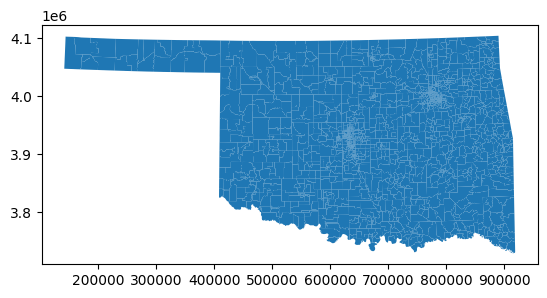

In [56]:
shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
shape=gpd.read_file(shapefile_path)
shape.plot()